In [1]:
# Movie recommender
# Data: https://www.kaggle.com/rounakbanik/the-movies-dataset/data
# - The data is similar to the movielend 20m dataset. Except it is more extensive and goes into 2017, not 2015

# Sources:
# http://antoinevastel.github.io/machine%20learning/python/2016/02/14/svd-recommender-system.html
# https://beckernick.github.io/matrix-factorization-recommender/
# https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html
# https://medium.com/@m_n_malaeb/singular-value-decomposition-svd-in-recommender-systems-for-non-math-statistics-programming-4a622de653e9

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import math
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

In [3]:
# Load the data
dataLoc = "~/Downloads/ratings.csv"
dataPD = pd.read_csv(dataLoc)
moviesLoc = "~/Downloads/movies_metadata.csv"
moviesPD = pd.read_csv(moviesLoc, low_memory=False)
moviesIdsLoc = "~/Downloads/links.csv"
moviesIdsLocPD = pd.read_csv(moviesIdsLoc)

In [4]:
# What does the rating data look like?
dataPD[0:10]

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
5,1,1968,4.0,1425942148
6,1,2762,4.5,1425941300
7,1,2918,5.0,1425941593
8,1,2959,4.0,1425941601
9,1,4226,4.0,1425942228


Rows: 104097156
Distinct movies: 45115
Distinct Users: 270896
First timestamp: 1995-01-09 12:46:44
Last timestamp: 2017-08-04 08:57:50


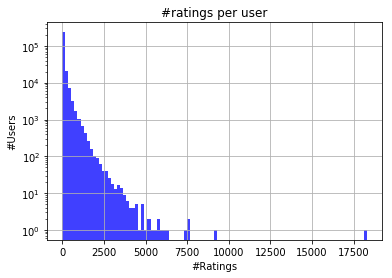

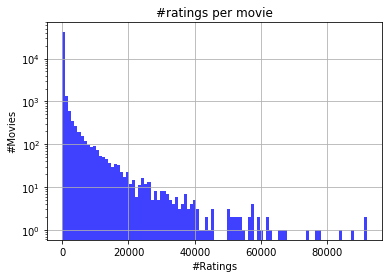

In [5]:
def showDataStats(inPD):
    """ Show selected statistics on given movie ratings dataframe
    """
    # Get some numbers
    print("Rows: {0}".format(inPD.size))
    print("Distinct movies: {0}".format(inPD['movieId'].unique().size))
    print("Distinct Users: {0}".format(inPD['userId'].unique().size))
    print("First timestamp: {0}".format(datetime.datetime.fromtimestamp(inPD['timestamp'].min()).strftime('%Y-%m-%d %H:%M:%S')))
    print("Last timestamp: {0}".format(datetime.datetime.fromtimestamp(inPD['timestamp'].max()).strftime('%Y-%m-%d %H:%M:%S')))
    
    # Plot some histograms to get a feeling for the data
    numRatingsPerUserPD = inPD.groupby('userId')['movieId'].count()
    n, bins, patches = plt.hist(numRatingsPerUserPD.as_matrix(), 100, log=True, facecolor='blue', alpha=0.75)
    plt.xlabel('#Ratings')
    plt.ylabel('#Users')
    plt.title('#ratings per user')
    plt.grid(True)
    plt.show()

    numRatingsPerMoviePD = inPD.groupby('movieId')['userId'].count()
    n, bins, patches = plt.hist(numRatingsPerMoviePD.as_matrix(), 100, log=True, facecolor='blue', alpha=0.75)
    plt.xlabel('#Ratings')
    plt.ylabel('#Movies')
    plt.title('#ratings per movie')
    plt.grid(True)
    plt.show()
showDataStats(dataPD)

In [6]:
# For ease of use w/o overwriting dataPD
filteredDataPD = dataPD

In [7]:
# Filter out the bottom 95% of the movies
numRatingsPerMoviePD = filteredDataPD.groupby('movieId')['userId'].count()
filterOutMoviesPD = numRatingsPerMoviePD[(numRatingsPerMoviePD <= np.percentile(numRatingsPerMoviePD, 95))]
filteredDataPD = filteredDataPD[~filteredDataPD['movieId'].isin(filterOutMoviesPD.index)]

In [8]:
# When necessary (for computing power reasons)
# Randomly filter out 90% of the users
distinctUsers = filteredDataPD['userId'].unique()
filterUsersPD = pd.DataFrame(distinctUsers, columns=['userId']).sample(frac=0.1)
filteredDataPD = filteredDataPD[filteredDataPD['userId'].isin(filterUsersPD['userId'])]

In [9]:
# Filter out the users with little ratings (10th percentile)
# And filter out the users with many ratings (90th percentile)
numRatingsPerUserPD = filteredDataPD.groupby('userId')['movieId'].count()
filterOutUsersPD = numRatingsPerUserPD[(numRatingsPerUserPD <= np.percentile(numRatingsPerUserPD, 10))
                              | (numRatingsPerUserPD >= np.percentile(numRatingsPerUserPD, 90))]
filteredDataPD = filteredDataPD[~filteredDataPD['userId'].isin(filterOutUsersPD.index)]

Rows: 4079288
Distinct movies: 2256
Distinct Users: 21536
First timestamp: 1995-01-09 12:46:49
Last timestamp: 2017-08-04 06:25:07


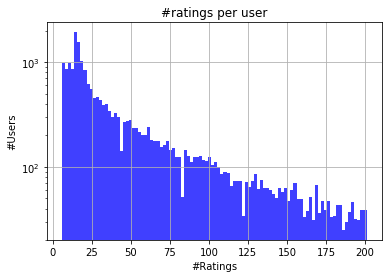

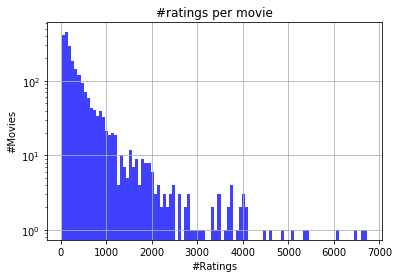

In [10]:
# Show stats
showDataStats(filteredDataPD)

In [11]:
# Convert pd dataframe to CF matrix (rating for each user, movie combination)
filteredDataMatPD = filteredDataPD.pivot(index = 'userId', columns = 'movieId', values = 'rating')

# For validation purposes, remove 20% of the elements from the data
#   - Remember these ratings as "test_set"
#   - Having our predictions, we can compare the recommendations with the "test_set"
#   - Note: x% of the elements does NOT implicate x% of the ratings. As it is a sparse matrix and random selection
randMat = np.random.random((filteredDataMatPD.shape[0], filteredDataMatPD.shape[1])) > 0.1
trainMat = np.multiply(filteredDataMatPD.as_matrix(),randMat)
testMat = np.multiply(filteredDataMatPD.as_matrix(),~randMat)

In [12]:
# Calculate mean per user
trainUserRatingsMean = np.nanmean(np.nan_to_num(trainMat,0), axis = 1)

# Substract mean from each element. The ratings are now mean normalized
trainMatMeanNormalized = trainMat - trainUserRatingsMean.reshape(-1, 1)

In [13]:
# Use svd and calculate collaborative rating matrix
#   - https://en.wikipedia.org/wiki/Singular-value_decomposition
u, s, vt = svds(trainMatMeanNormalized, k=20)
sigma = np.diag(s) # svds doesn't actually return a diagonal matrix as sigma
predictedRatings = np.dot(np.dot(u, sigma), vt) + trainUserRatingsMean.reshape(-1, 1) #(U.Sigma).VT + mean we subtracted before to get to the original range
predictedRatingsPD = pd.DataFrame(predictedRatings, columns = filteredDataMatPD.columns)

In [14]:
# Calculate rmse from predicted and actual values
# - Takes those elements from actual that are filled. 
#   Calculates rmse to value in predicted
def root_mean_squared_error(predicted, actual):
    predicted = predicted[actual.nonzero()].flatten() 
    actual = actual[actual.nonzero()].flatten()
    return math.sqrt(mean_squared_error(predicted, actual))

In [15]:
# Validate predictions on test holdout (RMSE)
root_mean_squared_error(predictedRatings, np.nan_to_num(testMat,0))

3.074056820764946

In [16]:
# Random predictions RMSE to test holdout
randomPredictions = np.random.random((filteredDataMatPD.shape[0], filteredDataMatPD.shape[1]))*5
root_mean_squared_error(randomPredictions, testMat)

2.146392970657304

In [17]:
def joinListToMovies(toJoin, moviesPD, moviesIdsLocPD):
    """ Retrieve top recommended movies for user
    """
    # Get ID with movies
    moviesPD['imdb_id'] = moviesPD['imdb_id'].apply(lambda x: str(x).replace('tt','0').strip('0')).replace('nan',0).replace('',0).fillna(0).astype(int)
    moviesIdsLocPD['tmdbId'] = moviesIdsLocPD['tmdbId'].fillna(0).astype(int)
    moviesIdsLocPD['imdbId'] = moviesIdsLocPD['imdbId'].fillna(0).astype(int)

    # Join tables, get necessary columns
    moviesIdsJoinedPD = moviesIdsLocPD.merge(moviesPD, left_on='imdbId', right_on='imdb_id', how='inner')
    moviesIdPD = pd.concat([moviesIdsJoinedPD['movieId'], moviesIdsJoinedPD['tmdbId'], moviesIdsJoinedPD['imdbId'], moviesIdsJoinedPD['original_title']], axis=1)
    
    # Join to given list
    toJoin = pd.DataFrame(toJoin).reset_index()
    toJoin.columns.values[1] = 'rating'
    joined = toJoin.merge(moviesIdPD, on='movieId')
    joined = pd.concat([joined['movieId'],joined['original_title'],joined['rating']],axis=1)
    
    return joined

In [18]:
# Get and print recommended movies for user i
i = filteredDataMatPD.index[0]
def recommend(i, filteredDataMatPD, predictedRatingsPD):
    x = filteredDataMatPD.T[i]
    y = predictedRatingsPD.T[i]
    actual = x[x.notnull()]
    predictedNotRated = y[~x.notnull()]
    return predictedNotRated.sort_values(ascending=False)
recommended = recommend(i, filteredDataMatPD, predictedRatingsPD)
joinListToMovies(recommended, moviesPD, moviesIdsLocPD)[0:10]

,movieId,original_title,rating
0,593,The Silence of the Lambs,5.995058
1,296,Pulp Fiction,5.781772
2,4993,The Lord of the Rings: The Fellowship of the Ring,3.413733
3,5952,The Lord of the Rings: The Two Towers,3.392573
4,2959,Fight Club,3.384389
5,858,The Godfather,3.051952
6,1213,GoodFellas,2.926579
7,318,The Shawshank Redemption,2.917469
8,47,Se7en,2.855948
9,1089,Reservoir Dogs,2.784442


In [19]:
# Print top rated movies for this user. To visually inspect taste is similar (or not)
def getTopRatedForUser(i, filteredDataMatPD):
    """ Retrieve top rated movies for user
    """
    return filteredDataMatPD.T[i][filteredDataMatPD.T[i].notnull()].sort_values(ascending=False)
topRated = getTopRatedForUser(i, filteredDataMatPD)
joinListToMovies(topRated, moviesPD, moviesIdsLocPD)[0:20]

,movieId,original_title,rating
0,3114,Toy Story 2,5.0
1,2023,The Godfather: Part III,5.0
2,2762,The Sixth Sense,5.0
3,1097,E.T. the Extra-Terrestrial,5.0
4,1221,The Godfather: Part II,5.0
5,3408,Erin Brockovich,5.0
6,2396,Shakespeare in Love,5.0
7,2763,The Thomas Crown Affair,4.0
8,4896,Harry Potter and the Philosopher's Stone,4.0
9,2706,American Pie,4.0
